In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml, fetch_california_housing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
    
from scipy.stats import loguniform, uniform, randint

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
census_data = fetch_openml(name='adult', version=2, as_frame=True)

df_X = census_data.data
s_y = census_data.target

df_dataset = df_X.copy(deep=True)
df_dataset["class"] = s_y

target_column = "class"

numerical feature histogram

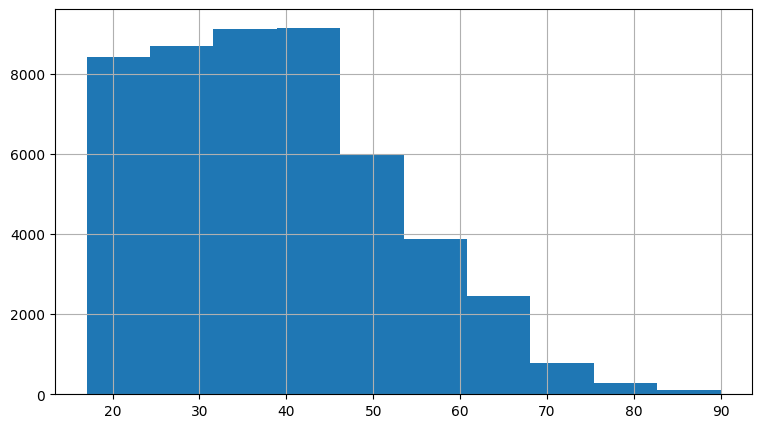

In [10]:
_ = df_X["age"].hist(figsize=(9, 5))

Joint distribution of a pair of variables

Text(0.5, 1.1, "Jointplot of 'age' vs 'hours-per-week' \nbefore StandardScaler")

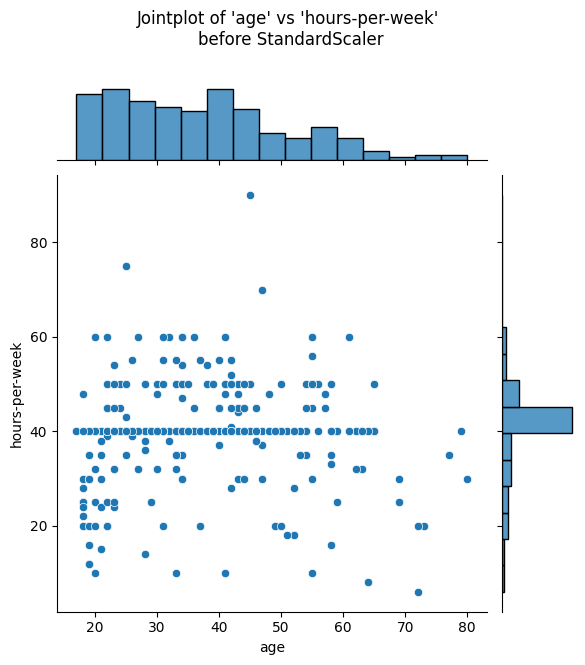

In [4]:
n_samples_to_plot = 300

sns.jointplot(
    data=df_dataset[:n_samples_to_plot],
    x="age",
    y="hours-per-week",
    marginal_kws=dict(bins=15),
)
plt.suptitle(
    "Jointplot of 'age' vs 'hours-per-week' \nbefore StandardScaler", y=1.1
)

Pair plot intercation with the target

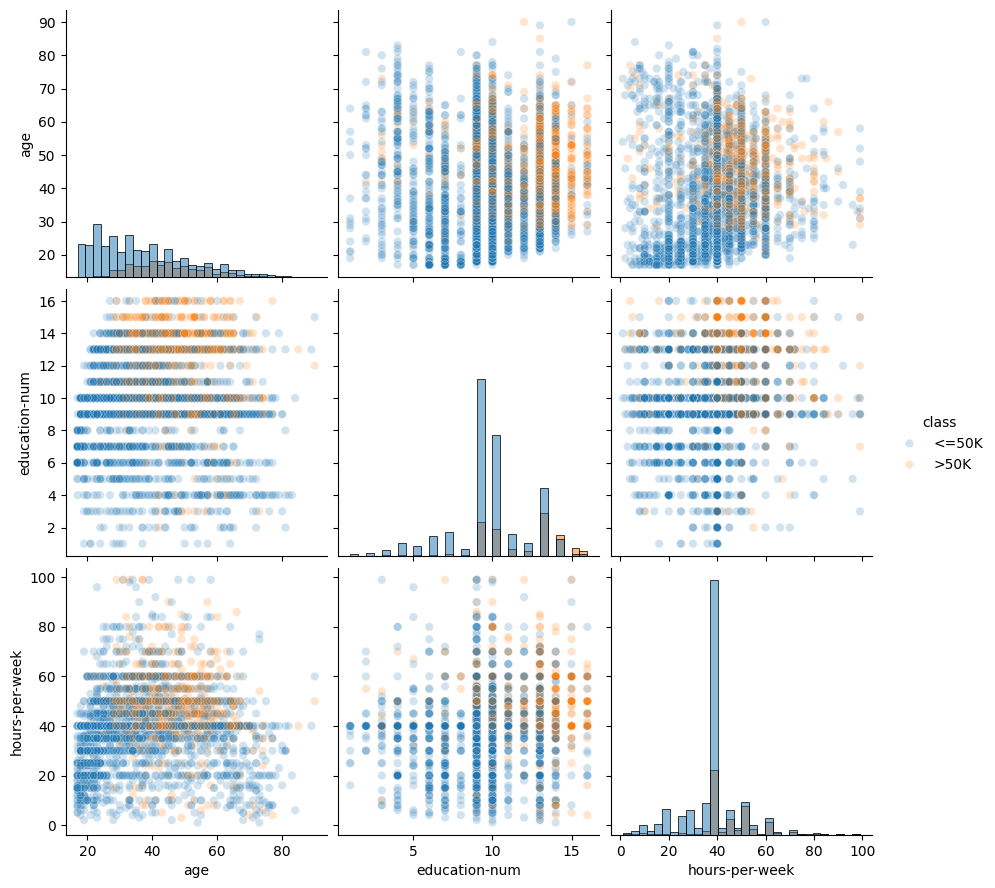

In [22]:
n_samples_to_plot = 5000
columns = ["age", "education-num", "hours-per-week"]

_ = sns.pairplot(
    data=df_dataset[:n_samples_to_plot],
    vars=columns,
    hue=target_column,
    plot_kws={"alpha": 0.2},
    height=3,
    diag_kind="hist",
    diag_kws={"bins": 30},
)

Single pair of variable interaction with the target

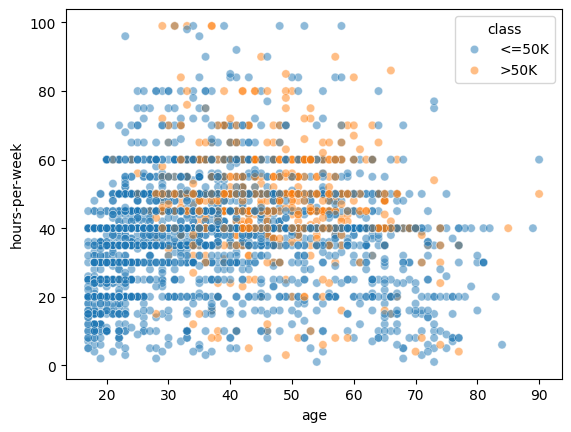

In [23]:
_ = sns.scatterplot(
    x="age",
    y="hours-per-week",
    data=df_dataset[:n_samples_to_plot],
    hue=target_column,
    alpha=0.5,
)

In [7]:


housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100

regressor = DecisionTreeRegressor()
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
cv_results = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=2,
)
cv_results = pd.DataFrame(cv_results)
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]
]

Histograms of different columns on the same graph.

*Also note the plt not ax syntax*


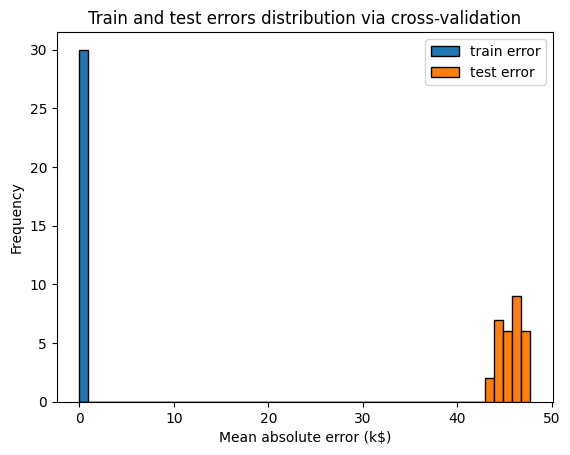

In [8]:
scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

Validation curves for a given hyperparameter.

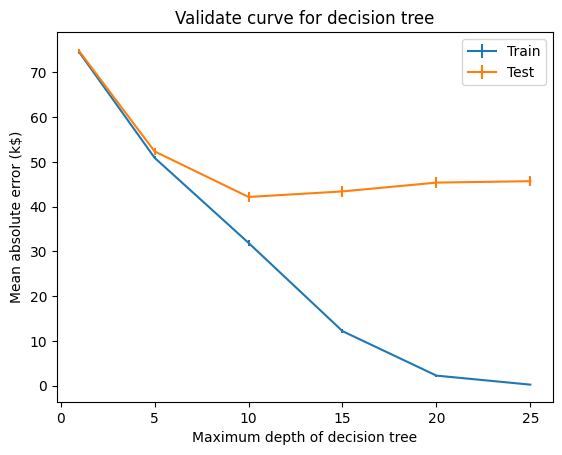

In [13]:
from sklearn.model_selection import ValidationCurveDisplay

max_depth = np.array([1, 5, 10, 15, 20, 25])
disp = ValidationCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    param_name="max_depth",
    param_range=max_depth,
    cv=cv,
    scoring="neg_mean_absolute_error",
    negate_score=True,
    std_display_style="errorbar",
    n_jobs=2,
)
_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="Mean absolute error (k$)",
    title="Validate curve for decision tree",
)

Learning Curve

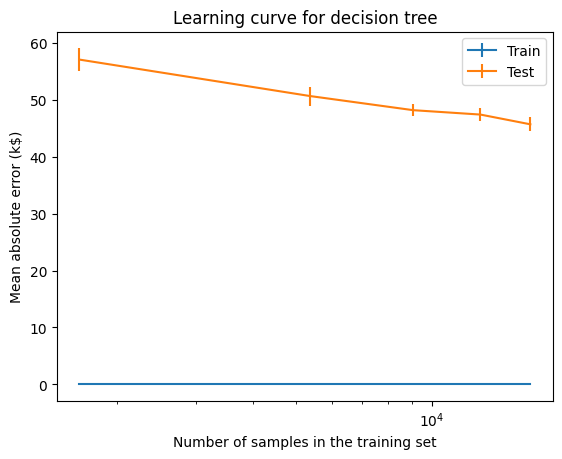

In [15]:
from sklearn.model_selection import LearningCurveDisplay

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

display = LearningCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    train_sizes=train_sizes,
    cv=cv,
    score_type="both",  # both train and test errors
    scoring="neg_mean_absolute_error",
    negate_score=True,  # to use when metric starts with "neg_"
    score_name="Mean absolute error (k$)",
    std_display_style="errorbar",
    n_jobs=2,
)
_ = display.ax_.set(xscale="log", title="Learning curve for decision tree")

#### Visualize cross validation results using an intervactive plot

In [3]:
class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)
    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [4]:
cat_col_selector = make_column_selector(dtype_include="category")
cols_cat = cat_col_selector(df_X)

preprocessor = ColumnTransformer([
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cols_cat),
    ],
    remainder="passthrough"
)

h_hgb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier())
])


In [4]:
param_distributions = {
    "classifier__l2_regularization": loguniform(1e-3, 10),
    "classifier__max_bins": loguniform_int(2, 256),
    "classifier__learning_rate": loguniform(1e-4, 1),
    "classifier__max_leaf_nodes": randint(2, 100),
    "classifier__min_samples_leaf": randint(2, 100),
}

h_searched = RandomizedSearchCV(
    estimator=h_hgb,
    n_iter=200,
    param_distributions=param_distributions,
    cv=3,
    verbose=1,
    error_score='raise'
)
h_searched.fit(df_X, s_y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


C:\Users\Pierre\miniconda3\envs\probabl\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country'])])),
                                             ('classifier',
                                              HistGradientBo...
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023A2528D310>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x0000023A251DE7B0>,
                                        'classifier__max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023A251DEBA0>,
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023A2528D450>},
                   verbose=1)

In [5]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

df_cv_res = pd.DataFrame(h_searched.cv_results_)
df_cv_res.rename(shorten_param, axis=1, inplace=True)
df_cv_res.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.522395      0.021638         0.042606        0.006740   
1       0.220336      0.006289         0.034411        0.001379   
2       0.376577      0.003600         0.036345        0.001522   
3       0.319859      0.003214         0.035572        0.000888   
4       0.137292      0.005951         0.027088        0.000152   

   l2_regularization  learning_rate  max_bins  max_leaf_nodes  \
0           0.151216       0.019123       108              96   
1           0.023340       0.016312         9              20   
2           0.005100       0.003940         5              49   
3           1.566202       0.001366        30              47   
4           2.759276       0.500815        49              66   

   min_samples_leaf                                             params  \
0                88  {'classifier__l2_regularization': 0.1512162277...   
1                79  {'classifier__l2_regularization': 0.0233397559...   
2                 6  {'classifier__l2_regularization': 0.0050995223...   
3                69  {'classifier__l2_regularization': 1.5662018539...   
4                 7  {'classifier__l2_regularization': 2.7592761924...   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.860758           0.857441           0.864128         0.860776   
1           0.839076           0.838585           0.841585         0.839749   
2           0.760703           0.760703           0.760749         0.760718   
3           0.760703           0.760703           0.760749         0.760718   
4           0.852343           0.853326           0.859828         0.855166   

   std_test_score  rank_test_score  
0        0.002730               28  
1        0.001314               78  
2        0.000022              112  
3        0.000022              112  
4        0.003321               41

In [13]:
fig = px.parallel_coordinates(
    df_cv_res.apply(
        {
            "learning_rate": np.log10,
            "max_leaf_nodes": np.log2,
            "max_bins": np.log10,
            "min_samples_leaf": np.log10,
            "l2_regularization": np.log10,
            "mean_test_score": lambda x: x,
        }
    ),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Turbo,
)
fig.show()

#### Compare cross validation results

In [8]:
cv_res_bins255 = cross_validate(
    estimator=h_hgb.set_params(classifier__max_bins=255),
    X=df_X,
    y=s_y,
    cv=10,
)
cv_res_bins128 = cross_validate(
    estimator=h_hgb.set_params(classifier__max_bins=128),
    X=df_X,
    y=s_y,
    cv=10,
)

df_comp = pd.DataFrame(
    np.array([cv_res_bins255['test_score'], cv_res_bins128['test_score']]).T,
    columns=['bins=255', 'bins=128']
)

(0.85, 0.9)

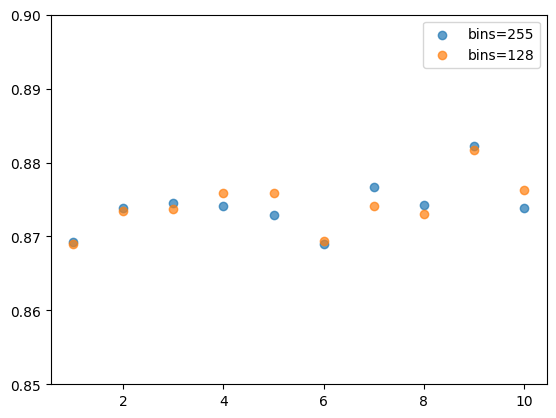

In [13]:
plt.scatter(df_comp.index + 1, df_comp["bins=255"], alpha=.7, label='bins=255')
plt.scatter(df_comp.index + 1, df_comp["bins=128"], alpha=.7, label='bins=128')
plt.legend()
ax = plt.gca()
ax.set_ylim(.85, .9)